In [2]:
import numpy as np

In [26]:
def f(x):
    f = np.zeros(len(x))
    for i in range(len(x)):
        f[i] = np.power(x[i], 4)/4 + np.power(x[i], 2)/2 + x[i]
    return f

def delta_f(x, method = 'exact', k = 10):
    if method == 'exact':
        return np.power(x, 3) + x + 1
    elif method =='forward':
        h = np.zeros(len(x))
        for i in range(len(x)):
            e = np.zeros(len(x))
            e[i] = 1
            h[i] = 10**(-k) * np.linalg.norm(x) * e[i]
        return (f(x+h) - f(x)) / h   
    elif method =='backward':
        h = np.zeros(len(x))
        for i in range(len(x)):
            e = np.zeros(len(x))
            e[i] = 1
            h[i] = 10**(-k) * np.linalg.norm(x) * e[i]
        return (f(x) - f(x-h)) / h
    elif method =='centered':
        h = np.zeros(len(x))
        for i in range(len(x)):
            e = np.zeros(len(x))
            e[i] = 1
            h[i] = 10**(-k) * np.linalg.norm(x) * e[i]
        return (f(x+h) - f(x-h)) / (2*h)      

def delta2_f(x):
    return 3 * np.power(x, 2) + 1

In [140]:
def steepest_descent(x0, kmax, tollgrad, descent_method = 'steepest', alpha = 2, grad_method = 'exact'):
    x = np.zeros((len(x0), kmax))
    x[:, 0] = x0
    
    p_k = -delta_f(x0)
    
    delta_fk_norm = np.linalg.norm(delta_f(x0))
    
    k = 0
    
    # constants for line search algorithm
    rho = 0.5
    jmax = 100
    c1_arm = 10**(-4)
    c1_wol = c1_arm
    c2_wol = 0.4
    
    if descent_method == 'steepest':
        while(k < kmax-1 and delta_fk_norm >= tollgrad):

            # Find alpha using line search(backtracking method)
            j = 0
            while j < jmax and (f(x[:, k] + alpha * p_k) > farmijo(x[:, k], alpha, p_k, c1=c1_arm)).all():
                alpha = alpha * rho
                j+=1
                
            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha * p_k

            p_k = -delta_f(x[:, k+1])

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1]))

            # Increase the step by one
            k += 1
    elif descent_method == 'fr':
        gradf_k = delta_f(x0)
        alpha_k = alpha
        while(k < kmax-1 and delta_fk_norm >= tollgrad):

            # Compute dk
            d_k = -gradf_k
            
            
            #TODO: Choose one method for finding alpha
            
            # Find alpha using line search(backtracking method)
            j = 0
            while (j < jmax and 
                (f(x[:, k] + alpha_k * p_k) > farmijo(x[:, k], alpha_k, p_k, c1=c1_wol)).all() and 
                (np.abs(delta_f(x[:, k] + alpha_k * p_k).T * p_k) > c2_wol * np.abs(delta_f(x[:, k]).T * p_k)).all()):
                
                alpha_k = alpha_k * rho
                j+=1
                    
            # Compute alpha[k]
#             alpha_k = (gradf_k.T @ gradf_k) / (d_k.T @ (delta2_f(x[:, k]) * d_k)) 

            # Our Q matrix is diagonal matrix with shape(10000, 10000). Such matrix requires a lot of storage. 
            # For this reason I use element-wise multiplication which is fine for our solution.

            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha_k * p_k

            # Compute the new value for gradfk
            gradf_k1 = delta_f(x[:, k+1])

            # Compute the new value for betak
            beta_k1 = (gradf_k1.T @ gradf_k1) / (gradf_k.T @ gradf_k) 

            # Compute the new value for pk
            p_k = -gradf_k1 + beta_k1 * p_k

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1]))

            # Increase the step by one
            k += 1
    elif descent_method == 'pr':
        gradf_k = delta_f(x0)
        alpha_k = alpha
        while(k < kmax-1 and delta_fk_norm >= tollgrad):

            # Compute dk
            d_k = -gradf_k

            #TODO: Choose one method for finding alpha
            
            # Find alpha using line search(backtracking method)
            j = 0
            while (j < jmax and 
                (f(x[:, k] + alpha_k * p_k) > farmijo(x[:, k], alpha_k, p_k, c1=c1_wol)).all() and 
                (np.abs(delta_f(x[:, k] + alpha_k * p_k).T * p_k) > c2_wol * np.abs(delta_f(x[:, k]).T * p_k)).all()):

                alpha_k = alpha_k * rho
                j+=1
            
            # Compute alpha[k]
#             alpha_k = (gradf_k.T @ gradf_k) / (d_k.T @ (delta2_f(x[:, k]) * d_k)) 

            # Our Q matrix is diagonal matrix with shape(10000, 10000). Such matrix requires a lot of storage. 
            # For this reason I use element-wise multiplication which is fine for our solution.

            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha_k * p_k

            # Compute the new value for gradfk
            gradf_k1 = delta_f(x[:, k+1])

            # Compute the new value for betak
            beta_k1 = (gradf_k1.T @ (gradf_k1 - gradf_k)) / (gradf_k.T @ gradf_k) 

            # Compute the new value for pk
            p_k = -gradf_k1 + beta_k1 * p_k

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1]))

            # Increase the step by one
            k += 1

    # Compute f(xk)
    fk = f(x[:, k-1]).sum()

    # "Cut" xseq to the correct size and return
    return x[:, :k], k-1, fk

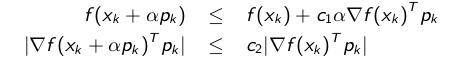

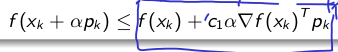

In [129]:
def farmijo(x, alpha, p, c1 = 10**(-4)):
    return f(x) + c1 * alpha * delta_f(x).T @ p



In [117]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)
# x0 = [2, 5]
alpha = 3
kmax = 1000
tol = 10**(-6)

In [141]:
steepest_descent(x0,  kmax, tol, alpha= alpha)

(array([[ 0.17534527, -0.26743089, -0.40120139, ..., -0.68232779,
         -0.6823278 , -0.6823278 ],
        [ 0.0189159 , -0.3631801 , -0.47360195, ..., -0.6823278 ,
         -0.6823278 , -0.6823278 ],
        [ 0.1043832 , -0.310187  , -0.43393101, ..., -0.68232779,
         -0.6823278 , -0.6823278 ],
        ...,
        [ 0.22335622, -0.23958091, -0.37958104, ..., -0.68232779,
         -0.6823278 , -0.6823278 ],
        [ 0.25602203, -0.22127931, -0.36525791, ..., -0.68232779,
         -0.6823278 , -0.6823278 ],
        [ 0.69188438, -0.06677519, -0.24169902, ..., -0.68232778,
         -0.68232779, -0.6823278 ]]),
 33,
 -3953.530449018225)

In [142]:
steepest_descent(x0,  kmax, tol,descent_method = 'fr')

(array([[ 0.17534527, -0.41502294, -0.72951445, ..., -0.6823279 ,
         -0.68232778, -0.68232781],
        [ 0.0189159 , -0.49054544, -0.73608342, ..., -0.68232793,
         -0.68232778, -0.68232781],
        [ 0.1043832 , -0.44837707, -0.73318428, ..., -0.68232792,
         -0.68232778, -0.68232781],
        ...,
        [ 0.22335622, -0.39389329, -0.72676492, ..., -0.68232789,
         -0.68232779, -0.68232781],
        [ 0.25602203, -0.38037976, -0.72491981, ..., -0.68232788,
         -0.68232779, -0.68232781],
        [ 0.69188438, -0.31966172, -0.74244096, ..., -0.68232793,
         -0.68232778, -0.68232781]]),
 12,
 -3953.5304490182243)

In [143]:
steepest_descent(x0,  kmax, tol,descent_method='pr')

(array([[ 0.17534527, -0.41502294, -0.55508649, ..., -0.68232782,
         -0.6823278 , -0.6823278 ],
        [ 0.0189159 , -0.49054544, -0.58555991, ..., -0.68232776,
         -0.68232781, -0.6823278 ],
        [ 0.1043832 , -0.44837707, -0.56986782, ..., -0.6823278 ,
         -0.6823278 , -0.6823278 ],
        ...,
        [ 0.22335622, -0.39389329, -0.54439472, ..., -0.68232784,
         -0.6823278 , -0.68232781],
        [ 0.25602203, -0.38037976, -0.53689095, ..., -0.68232784,
         -0.6823278 , -0.68232781],
        [ 0.69188438, -0.31966172, -0.44357339, ..., -0.6823278 ,
         -0.6823278 , -0.6823278 ]]),
 12,
 -3953.530449018225)

In [71]:
x_seq, k, fk = steepest_descent(x0,  kmax, tol, alpha = alpha)

In [96]:
fk

-39535.304490182265

In [162]:
x_seq[:,k-1]

array([-0.6823278, -0.6823278, -0.6823278, ..., -0.6823278, -0.6823278,
       -0.6823278])

In [99]:
x_seq

array([[ 0.87672636,  0.80020772,  0.73082952, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ],
       [ 0.09457948,  0.06171672,  0.02985816, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ],
       [ 0.52191602,  0.4719935 ,  0.42467921, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ],
       ...,
       [ 2.09480059,  1.72618511,  1.49009337, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ],
       [ 1.48428634,  1.31165655,  1.17460795, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ],
       [ 4.01296899,  1.92384396,  1.62251411, ..., -0.6823278 ,
        -0.6823278 , -0.6823278 ]])

In [116]:
x_seq_fr, k_fr, fk_fr = fr(x0, kmax, tol)

0.4172290753398313


In [117]:
x_seq_fr[:, k_fr]

array([-0.68234031, -0.68233874, -0.68234031, ..., -0.68234031,
       -0.68234031, -0.68234031])

In [118]:
fk_fr

-39535.304471643656

In [113]:
k_fr

7

In [30]:
x_seq_pr, k_pr, fk_pr = pr(x0, kmax, tol)

[-0.6823278 -0.6823278 -0.6823278 ... -0.6823278 -0.6823278 -0.6823278]


In [27]:
x_seq_pr

array([[ 0.87672636,  0.83310573,  0.75480019, ..., -0.68834753,
        -0.68234025, -0.6823278 ],
       [ 0.09457948,  0.07584555,  0.04053627, ..., -0.68375106,
        -0.68229948, -0.6823278 ],
       [ 0.52191602,  0.49345692,  0.44070077, ..., -0.68572819,
        -0.68232016, -0.6823278 ],
       ...,
       [ 2.09480059,  1.88466564,  1.59153962, ..., -0.68959058,
        -0.6823499 , -0.6823278 ],
       [ 1.48428634,  1.38587607,  1.22541423, ..., -0.68943525,
        -0.68234814, -0.6823278 ],
       [ 4.01296899,  2.82203101,  2.31624996, ..., -0.68965958,
        -0.68235109, -0.6823278 ]])

In [28]:
k_pr

9

In [5]:
v = [2, 4, 10]

In [7]:
delta_f(v, method='forward')

array([1091.00040356, 1091.00040356, 1091.00040356])

In [6]:
delta_f(v)

array([  11,   69, 1011])

In [147]:
for k in range(2,4,2):
    print(k, delta_f(v,method='centered', k=k))

2 [  11.0258  131.0645 1011.129 ]


In [49]:
a = np.zeros(5)

In [51]:
a[2] = 1

In [52]:
a

array([0., 0., 1., 0., 0.])

In [ ]:
while (bt< btmax and (fnew>farmijo(fk, alpha, xk, pk, gradf, c1)).all()):
    alpha = rho * alpha
    xnew = xk + alpha*pk
    fnew = f(xnew)
    bt = bt+1 

In [85]:
def steep(x0, kmax, tollgrad, descent_method = 'steepest', alpha = 0.2, grad_method = 'exact'):
    x = np.zeros((len(x0), kmax))
    x[:, 0] = x0
    
    p_k = -delta_f(x0)
    
    delta_fk_norm = np.linalg.norm(delta_f(x0))
    
    k = 0
    
    rho = 0.5
    
    while(k < kmax-1 and delta_fk_norm >= tollgrad):

        j = 0
        jmax = 100
        while j < jmax and (f(x[:, k] + alpha * p_k) > farmijo(x[:, k], alpha, p_k)).all():
            alpha = alpha * rho
            j+=1
        print(j, alpha)
        
        # Compute the new value for xk
        x[:, k+1] = x[:, k] + alpha * p_k

        
        p_k = -delta_f(x[:, k+1])

        # Compute the gradient of f in xk
        delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1]))

        # Increase the step by one
        k += 1
   
    # Compute f(xk)
    fk = f(x[:, k-1]).sum()

    # "Cut" xseq to the correct size and return
    return x[:, :k], k-1, fk

In [86]:
steepest_descent(x0, kmax, tol, alpha=0.3)

(array([[ 0.17534527, -0.17887566, -0.42349594, ..., -0.68232777,
         -0.68232779, -0.6823278 ],
        [ 0.0189159 , -0.2867609 , -0.49365837, ..., -0.68232778,
         -0.6823278 , -0.6823278 ],
        [ 0.1043832 , -0.22727296, -0.45556927, ..., -0.68232777,
         -0.6823278 , -0.6823278 ],
        ...,
        [ 0.22335622, -0.14699348, -0.40194261, ..., -0.68232776,
         -0.68232779, -0.6823278 ],
        [ 0.25602203, -0.12581904, -0.3874758 , ..., -0.68232776,
         -0.68232779, -0.6823278 ],
        [ 0.69188438,  0.08495672, -0.24071425, ..., -0.68232771,
         -0.68232778, -0.6823278 ]]),
 17,
 -3953.530449018225)

In [101]:
steep(x0, kmax, tol, alpha = 3)[1]

2 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75
0 0.75


75